In [1]:
import sys
sys.path.append('/home/yg534/OOD-detection-using-OECC')

In [3]:
%reload_ext autoreload
%autoreload 2
import os, sys, argparse, time
sys.path.append('..')

import pickle
import torch
import seaborn as sns
import torch.nn as nn
import numpy as np
import torch.backends.cudnn as cudnn
import torchvision.transforms as trn
import torchvision.datasets as dset
from torch.utils.data import Subset
import torch.nn.functional as F
from tqdm import tqdm_notebook, tqdm
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage
import seaborn as sns

from CIFAR.models.wrn import WideResNet 
from utils.display_results import show_performance, get_measures, print_measures, print_measures_with_std
import utils.svhn_loader as svhn
import utils.lsun_loader as lsun_loader

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [4]:
args = {
        'calibration': '',
        'epochs': 100,
        'dataset':'cifar10',
        'learning_rate': 0.1,
        'batch_size': 128,
        'test_bs': 200,
        'model':'wrn',
        'momentum': 0.9,
        'decay': 0.0005,
        'save':'/home/yg534/OOD-detection-using-OECC/CIFAR/',
        'load': '',
        'test': 'store_true',
        'layers':40,
        'widen_factor':2,
        'droprate':0.3,
        'ngpu': 4,
        'prefetch': 4,    
        }

In [5]:
root='/home/yg534/OOD-detection-using-OECC/CIFAR/dataset'

state = {k: v for k, v in args.items()}

torch.manual_seed(1)
np.random.seed(1)


# mean and standard deviation of channels of CIFAR-10 images
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = trn.Compose([trn.RandomHorizontalFlip(), trn.RandomCrop(32, padding=4),
                               trn.ToTensor(), trn.Normalize(mean, std)])
test_transform = trn.Compose([trn.ToTensor(), trn.Normalize(mean, std)])

def get_target_label_idx(labels, targets):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    return np.argwhere(np.isin(labels, targets)).flatten().tolist()


# cifar 10 train
cifar_10_train = dset.CIFAR10(root, train=True, download=True, transform=train_transform)
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_idx_list = np.arange(len(cifar_10_train))
train_local_idx = get_target_label_idx(cifar_10_train.targets, [0, 1, 2, 5, 6, 7, 8, 9])
print(len(train_local_idx))
train_data = Subset(cifar_10_train, train_local_idx)

# cifar 10 test
cifar_10_test = dset.CIFAR10(root, train=False, download=True, transform=test_transform)
test_idx_list = np.arange(len(cifar_10_test))
test_local_idx = get_target_label_idx(cifar_10_test.targets, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(len(test_local_idx))
test_data = Subset(cifar_10_test, test_local_idx)
num_classes = 10

calib_indicator = ''
if args['calibration']:
    train_data, val_data = validation_split(train_data, val_share=0.1)
    calib_indicator = '_calib'

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=args['batch_size'], shuffle=True,
    num_workers=args['prefetch'], pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=args['test_bs'], shuffle=False,
    num_workers=args['prefetch'], pin_memory=True)

0it [00:00, ?it/s]

Extracting /home/yg534/OOD-detection-using-OECC/CIFAR/cifar-10-python.tar.gz to /home/yg534/OOD-detection-using-OECC/CIFAR/
40000
Files already downloaded and verified
10000


In [6]:
# Create model
net = WideResNet(args['layers'], num_classes, args['widen_factor'], dropRate=args['droprate'])

start_epoch = 0

# Restore model if desired
if args['load'] != '':
    for i in range(1000 - 1, -1, -1):
        model_name = os.path.join( args['load'], args['dataset'] + calib_indicator + '_' + args['model'] +
                                  '_baseline_epoch_' + str(i) + '.pt')
        if os.path.isfile(model_name):
            net.load_state_dict(torch.load(model_name))
            print('Model restored! Epoch:', i)
            start_epoch = i + 1
            break
    if start_epoch == 0:
        assert False, "could not resume"

net.cuda()
torch.cuda.manual_seed(1)
cudnn.benchmark = True  # fire on all cylinders

optimizer = torch.optim.SGD(
    net.parameters(), state['learning_rate'], momentum=state['momentum'],
    weight_decay=state['decay'], nesterov=True)


def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))


scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        args['epochs'] * len(train_loader),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / args['learning_rate']))

In [7]:
# /////////////// Training ///////////////
def train():
    net.train()  # enter train mode
    loss_avg = 0.0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()

        # forward
        x = net(data)

        # backward
        scheduler.step()
        optimizer.zero_grad()
        loss = F.cross_entropy(x, target)
        loss.backward()
        optimizer.step()

        # exponential moving average
        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

    state['train_loss'] = loss_avg

# test function
def test():
    net.eval()
    loss_avg = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()

            # forward
            output = net(data)
            loss = F.cross_entropy(output, target)

            # accuracy
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).sum().item()

            # test loss average
            loss_avg += float(loss.data)        
    
    state['test_loss'] = loss_avg / len(test_loader)
    state['test_accuracy'] = correct / len(test_loader.dataset)


# Make save directory
if not os.path.exists(args['save']):
    os.makedirs(args['save'])
if not os.path.isdir(args['save']):
    raise Exception('%s is not a dir' % args['save'])

with open(os.path.join(args['save'], args['dataset'] + calib_indicator + '_' + args['model'] +
                                  '_baseline_training_results.csv'), 'w') as f:
    f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

print('Beginning Training\n')

# Main loop
for epoch in range(start_epoch, args['epochs']):
    state['epoch'] = epoch

    begin_epoch = time.time()

    train()
    test()

    # Save model
    torch.save(net.state_dict(),
               os.path.join('/home/yg534/OOD-detection-using-OECC/CIFAR/models/cam1_model' + '.pt'))


    # Show results

    with open(os.path.join(args['save'], args['dataset'] + calib_indicator + '_' + args['model'] +
                                      '_baseline_training_results.csv'), 'a') as f:
        f.write('%03d,%05d,%0.6f,%0.5f,%0.2f\n' % (
            (epoch + 1),
            time.time() - begin_epoch,
            state['train_loss'],
            state['test_loss'],
            100 - 100. * state['test_accuracy']
        ))

    print('Epoch {0:3d} | Time {1:5d} | Train Loss {2:.4f} | Test Loss {3:.3f} | Test Error {4:.2f}'.format(
        (epoch + 1),
        int(time.time() - begin_epoch),
        state['train_loss'],
        state['test_loss'],
        100 - 100. * state['test_accuracy'])
    )


Beginning Training



/home/yg534/.conda/envs/torch-gpu/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch   1 | Time    18 | Train Loss 1.0392 | Test Loss 3.175 | Test Error 53.76
Epoch   2 | Time    17 | Train Loss 0.6893 | Test Loss 3.275 | Test Error 46.21
Epoch   3 | Time    17 | Train Loss 0.6582 | Test Loss 2.823 | Test Error 43.13
Epoch   4 | Time    17 | Train Loss 0.5706 | Test Loss 2.892 | Test Error 41.20
Epoch   5 | Time    17 | Train Loss 0.5375 | Test Loss 2.695 | Test Error 39.09
Epoch   6 | Time    17 | Train Loss 0.4495 | Test Loss 2.246 | Test Error 34.17
Epoch   7 | Time    17 | Train Loss 0.4884 | Test Loss 2.283 | Test Error 35.40
Epoch   8 | Time    17 | Train Loss 0.4467 | Test Loss 2.466 | Test Error 34.55
Epoch   9 | Time    17 | Train Loss 0.3741 | Test Loss 2.458 | Test Error 34.34
Epoch  10 | Time    17 | Train Loss 0.4052 | Test Loss 2.296 | Test Error 34.22
Epoch  11 | Time    17 | Train Loss 0.4131 | Test Loss 2.384 | Test Error 33.54
Epoch  12 | Time    17 | Train Loss 0.4135 | Test Loss 2.323 | Test Error 31.44
Epoch  13 | Time    17 | Train Loss 0.39

In [14]:
path = F"/content/drive/MyDrive/distributed_learning/OOD-detection-using-OECC/CIFAR/baseline model/baseline_model.pt"
torch.save(net.state_dict(), path)

In [ ]:
net.eval()


# /////////////// Detection Prelims ///////////////

ood_num_examples = len(test_data) // 5
expected_ap = ood_num_examples / (ood_num_examples + len(test_data))

concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.cpu().numpy()


def get_ood_scores(loader, in_dist=False):
    _score = []
    out_conf_score = []
    in_conf_score = []
    _right_score = []
    _wrong_score = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            if batch_idx >= ood_num_examples // args[
                    'test_bs'] and in_dist is False:
                break

#             data = data.cuda(device)
            data = data.cuda()

            output = net(data)
            smax = to_np(F.softmax(output, dim=1))

            if True:
                _score.append(
                    to_np((output.mean(1) - torch.logsumexp(output, dim=1))))
                out_conf_score.append(np.max(smax, axis=1))
            else:
                _score.append(-np.max(smax, axis=1))
                out_conf_score.append(np.max(smax, axis=1))

            if in_dist:
                in_conf_score.append(np.max(smax, axis=1))
                preds = np.argmax(smax, axis=1)
                targets = target.numpy().squeeze()
                right_indices = preds == targets
                wrong_indices = np.invert(right_indices)

                if False:
                    _right_score.append(
                        to_np((output.mean(1) -
                               torch.logsumexp(output, dim=1)))[right_indices])
                    _wrong_score.append(
                        to_np((output.mean(1) -
                               torch.logsumexp(output, dim=1)))[wrong_indices])
                else:
                    _right_score.append(-np.max(smax[right_indices], axis=1))
                    _wrong_score.append(-np.max(smax[wrong_indices], axis=1))

    if in_dist:
        return concat(in_conf_score).copy(), concat(_score).copy(), concat(_right_score).copy(), concat(_wrong_score).copy()
    else:
        return concat(out_conf_score).copy(), concat(_score)[:ood_num_examples].copy()


in_conf_score, in_score, right_score, wrong_score = get_ood_scores(test_loader, in_dist=True)

num_right = len(right_score)
num_wrong = len(wrong_score)
print('Error Rate {:.2f}'.format(100 * num_wrong / (num_wrong + num_right)))
# f.write('\nError Rate {:.2f}'.format(100 * num_wrong /
#                                      (num_wrong + num_right)))

# /////////////// End Detection Prelims ///////////////

print('\nUsing CIFAR-10 as typical data') if num_classes == 10 else print(
    '\nUsing CIFAR-100 as typical data')
# f.write('\nUsing CIFAR-10 as typical data') if num_classes == 10 else f.write(
#     '\nUsing CIFAR-100 as typical data')

# /////////////// Error Detection ///////////////

# print('\n\nError Detection')
# f.write('\n\nError Detection')
# show_performance(wrong_score, right_score, f, method_name=args['method_name'])

# /////////////// OOD Detection ///////////////
auroc_list, aupr_list, fpr_list = [], [], []


def get_and_print_results(ood_loader, num_to_avg=1):

    aurocs, auprs, fprs = [], [], []
    for _ in range(num_to_avg):
        out_conf_score, out_score = get_ood_scores(ood_loader)
        measures = get_measures(out_score, in_score)
        aurocs.append(measures[0])
        auprs.append(measures[1])
        fprs.append(measures[2])

    auroc = np.mean(aurocs)
    aupr = np.mean(auprs)
    fpr = np.mean(fprs)
    auroc_list.append(auroc)
    aupr_list.append(aupr)
    fpr_list.append(fpr)

    if num_to_avg >= 5:
        print_measures_with_std(aurocs, auprs, fprs, f, 'cifar10_wrn_OECC_tune')
    else:
        print_measures(auroc, aupr, fpr, f, 'cifar10_wrn_OECC_tune')
    return out_conf_score    




# /////////////// CIFAR Data ///////////////


ood_idx = get_target_label_idx(cifar_10_train.targets, [3, 4])
ood_data = Subset(cifar_10_train, ood_idx)



ood_loader = torch.utils.data.DataLoader(ood_data,
                                         batch_size=args['test_bs'],
                                         shuffle=True,
                                         num_workers=args['prefetch'],
                                         pin_memory=True)

print(
    '\n\nCIFAR-100 Detection') if True else print(
        '\n\nCIFAR-10 Detection')
# f.write('\n\nCIFAR-100 Detection'
#         ) if 'cifar10_' in args['method_name'] else f.write(
#             '\n\nCIFAR-10 Detection')
get_and_print_results(ood_loader)
out_conf_score, out_score = get_ood_scores(ood_loader, in_dist=False)
# /////////////// Mean Results ///////////////

print('\n\nMean Test Results')
# f.write('\n\nMean Test Results')
print_measures(np.mean(auroc_list),
               np.mean(aupr_list),
               np.mean(fpr_list),
               f,
               method_name='cifar10_wrn_OECC_tune')
# f.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Error Rate 3.70

Using CIFAR-10 as typical data


CIFAR-100 Detection
FPR95:			57.38
AUROC: 			87.75
AUPR:  			62.96


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Mean Test Results
FPR95:			57.38
AUROC: 			87.75
AUPR:  			62.96


In [ ]:
in_score

array([-0.99999666, -0.99549496, -0.9985436 , ..., -0.9997445 ,
       -0.9999893 , -0.99996316], dtype=float32)

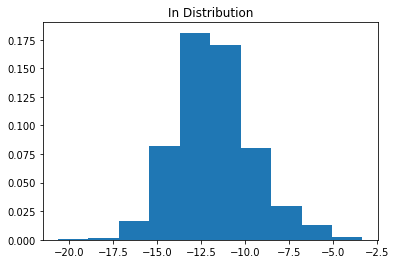

In [ ]:
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(in_score, density=True)

ax.set_title(r'In Distribution')

# Tweak spacing to prevent clipping of ylabel
plt.show()

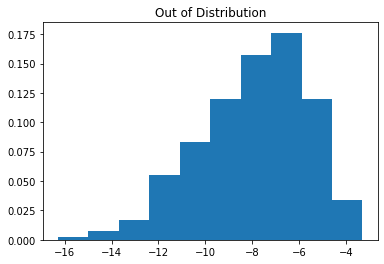

In [ ]:
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(out_score, density=True)

ax.set_title(r'Out of Distribution')

# Tweak spacing to prevent clipping of ylabel
plt.show()